In [ ]:
from nbdev import *
%nbdev_default_export data

Cells will be exported to deepflash2.data,
unless a different module is specified after an export flag: `%nbdev_export special.module`


In [ ]:
%nbdev_export
import os
import numpy as np
import imageio

from scipy import ndimage
from scipy.interpolate import Rbf
from scipy.interpolate import interp1d

from matplotlib.patches import Rectangle
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from fastai.vision.all import *
from fastcore.utils import store_attr

# Data

> This module defines tools for image data preprocessing and real-time data augmentation that is used to train a model.

__Original Paper:__ Falk, Thorsten, et al. "U-Net: deep learning for cell counting, detection, and morphometry." Nature methods 16.1 (2019): 67-70.

The code was provided by the authors and adapted for this package.

## Plot images and masks

In [ ]:
%nbdev_export
def show(*obj, file_name=None, overlay=False, pred=False,
         show_bbox=True, figsize=(10,10), cmap='binary_r', **kwargs):
    "Show image, mask, and weight (optional)"
    if isinstance(obj[1], tuple):
        img,msk,weight = obj[0], obj[1][0], obj[1][1]
    elif len(obj)>2:
        img,msk,weight = obj
    else:
        img,msk = obj
        weight = None

    # To numpy
    img = np.array(img)
    msk = np.array(msk)

    # Swap axis to channels last
    if img.shape[0]<10: img=np.moveaxis(img,0,-1)
    # One channel images
    if img.shape[-1]==1: img=img[...,0]

    # Remove background class from masks
    if msk.shape[0]==2: msk=msk[1,...]
    # Create bbox

    pad = (np.array(img.shape[:2])-np.array(msk.shape))//2
    bbox = Rectangle((pad[0]-1,pad[1]-1),img.shape[0]-2*pad[0]+1,img.shape[0]-2*pad[0]+1,
             edgecolor='r',linewidth=1,facecolor='none')

    # Padding mask and weights
    msk = np.pad(msk, pad, 'constant', constant_values=(0))
    if weight is not None:
        weight = np.array(weight)
        weight = np.pad(weight, pad, 'constant', constant_values=(0))

    if cmap is None:
        cmap = 'binary_r' if msk.max()==1 else cmap

    ncol=2 if weight is None else 3
    fig, ax = plt.subplots(1,ncol,figsize=figsize)
    # Plot img
    ax[0].imshow(img, cmap=cmap)
    if file_name is not None:
        ax[0].set_title('Image {}'.format(file_name))
    else:
        ax[0].set_title('Image')
    ax[0].set_axis_off()

    # Plot img and mask
    if overlay:
        label_image = label(msk)
        img_l2o = label2rgb(label_image, image=img, bg_label=0, alpha=.8, image_alpha=1)
        ax[1].set_title('Image + Mask (#ROIs: {})'.format(label_image.max()))
        ax[1].imshow(img_l2o)
    else:
        ax[1].imshow(msk, cmap=cmap)
        ax[1].set_title('Mask')
    if show_bbox: ax[1].add_patch(copy(bbox))

    ax[1].set_axis_off()

    # Plot weights
    if weight is not None:
        max_w = weight.max()
        vmax_w = max(1, max_w)
        ax[2].imshow(weight, vmax=vmax_w, cmap=cmap)
        if pred:
            ax[2].set_title('Prediction')
        else:
            ax[2].set_title('Weights (max value: {:.{p}f})'.format(max_w, p=1))
        if show_bbox: ax[2].add_patch(copy(bbox))
        ax[2].set_axis_off()

    #ax.set_axis_off()
    plt.tight_layout()
    plt.show()

The show methods in fastai all rely on some types being able to show themselves. We create a new type with a show method.

#### Typedispatch

Custom `show_batch` and `show_results` for  `DataLoader`

In [ ]:
%nbdev_export
@typedispatch
def show_batch(x:TensorImage, y:tuple, samples, max_n=6, figsize=None, **kwargs):
    "Show one batch (image, mask, and weights) from a `DataLoader`"
    max_n = np.min((max_n, len(x)))
    if figsize is None: figsize = (12, max_n * 5)
    for i in range(max_n): show(x[i], y[0][i], y[1][i], figsize=figsize, **kwargs)

In [ ]:
%nbdev_export
@typedispatch
def show_results(x:TensorImage, y:tuple, samples, outs, max_n=4, figsize=None, **kwargs):
    "Show image, mask, and weights from `max_n` items"
    max_n = np.min((max_n, len(x)))
    if figsize is None: figsize = (12, max_n * 5)
    for i in range(max_n): show(x[i], y[0][i], outs[i][0], pred=True, figsize=figsize, **kwargs)

__Example image and mask__

We will use an example image and mask to guide through the documentation.

In [ ]:
%nbdev_hide
# Generate an initial random image and mask with two circles
x, y = np.indices((540, 540))
x1, y1, x2, y2 = 180, 180, 44*7, 52*7
r1, r2 = 10*7, 20*7
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
mask = np.logical_or(mask_circle1, mask_circle2).astype(int)
image = np.random.rand(*mask.shape)+mask*2.
#image[mask==1] = np.abs(image[mask==1])+1
path=Path('sample_data')
(path/'images').mkdir(parents=True, exist_ok=True)
imageio.imsave(path/'images'/'01.png', image)
(path/'labels').mkdir(parents=True, exist_ok=True)
imageio.imsave(path/'labels'/'01_mask.png', (mask*255).astype('uint8'))

Lossy conversion from float64 to uint8. Range [2.4564373095614656e-06, 2.999992000750119]. Convert image to uint8 prior to saving to suppress this warning.


Plot example image and mask

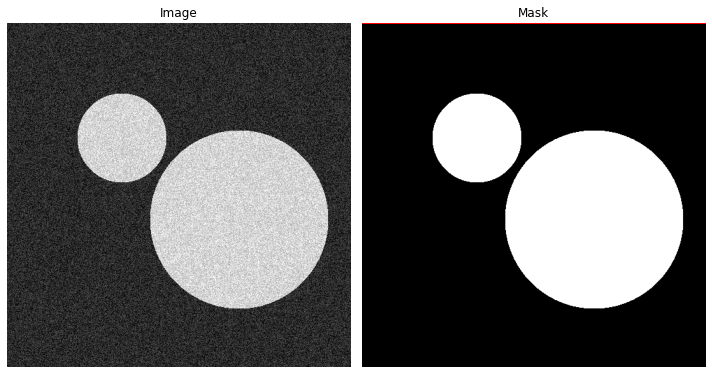

In [ ]:
image = imageio.imread(path/'images'/'01.png')
mask = imageio.imread(path/'labels'/'01_mask.png')
show(image, mask)

## Weight Calculation

We calculate the weight for the weighted softmax cross entropy loss from the given mask (classlabels).

In [ ]:
%nbdev_export
def calculate_weights(clabels=None, instlabels=None, ignore=None,
                      n_dims = 2, bws=6, fds=1, bwf=50, fbr=.1):
    """
    Calculates the weights from the given mask (classlabels `clabels` or `instlabels`).
    """

    assert not (clabels is None and instlabels is None), "Provide either clabels or instlabels"

    # If no classlabels are given treat the problem as binary segmentation
    # ==> Create a new array assigning class 1 (foreground) to each instance
    if clabels is None:
        clabels = (instlabels > 0).astype(int)

    # Initialize label and weights arrays with background
    labels = np.zeros_like(clabels)
    wghts = fbr * np.ones_like(clabels)
    frgrd_dist = np.zeros_like(clabels, dtype='float32')
    classes = np.unique(clabels)[1:]

    # If no instance labels are given, generate them now
    if instlabels is None:
        # Creating instance labels from mask
        instlabels = np.zeros_like(clabels)
        nextInstance = 1
        for c in classes:
            comps, nInstances = ndimage.measurements.label(clabels == c)
            instlabels[comps > 0] = comps[comps > 0] + nextInstance
            nextInstance += nInstances

    for c in classes:
        # Extract all instance labels of class c
        instances = np.unique(instlabels * (clabels == c))[1:]

        # Generate background ridges between touching instances
        # of that class, avoid overlapping instances
        for instance in instances:
            objectMaskDil = ndimage.morphology.binary_dilation(
                labels == c, structure=np.ones((3,) * n_dims))
            labels[(instlabels == instance) & (objectMaskDil == 0)] = c

        # Generate weights
        min1dist = 1e10 * np.ones(labels.shape)
        min2dist = 1e10 * np.ones(labels.shape)
        for instance in instances:
            dt = ndimage.morphology.distance_transform_edt(instlabels != instance)

            frgrd_dist += np.exp(-dt ** 2 / (2*fds ** 2))
            min2dist = np.minimum(min2dist, dt)
            newMin1 = np.minimum(min1dist, min2dist)
            newMin2 = np.maximum(min1dist, min2dist)
            min1dist = newMin1
            min2dist = newMin2
        wghts += bwf * np.exp(
            -(min1dist + min2dist) ** 2 / (2*bws ** 2))

    # Set weight for distance to the closest foreground object
    wghts[labels == 0] += (1-fbr)*frgrd_dist[labels == 0]
    # Set foreground weights to 1
    wghts[labels > 0] = 1
    pdf = (labels > 0) + (labels == 0) * fbr

    # Set weight and sampling probability for ignored regions to 0
    if ignore is not None:
        wghts[ignore] = 0
        pdf[ignore] = 0

    return (labels.astype(np.int32),
            wghts.astype(np.float32),
            pdf.astype(np.float32))

Arguments in `calculate_weights`:
- `clabels`: class labels (segmentation mask), 
- `instlabels`: instance labels (segmentation mask), 
- `ignore`: ignored reagions,
- `n_dims` (int) = number of classes for `clabels` 
- `bws` (float): border_weight_sigma in pixel
- `fds` (float): foreground_dist_sigma in pixel
- `bwf` (float): border_weight_factor 
- `fbr` (float): foreground_background_ratio

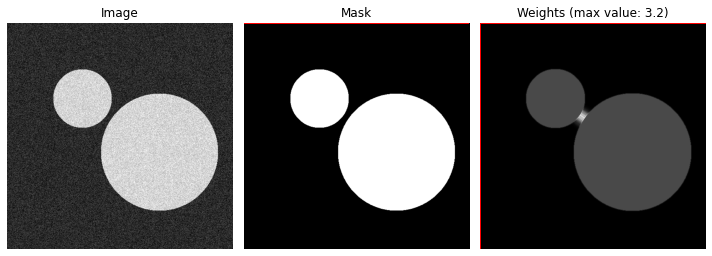

In [ ]:
labels, weights, _ =  calculate_weights(clabels=mask)
titles = ['Labels (Mask)', 'Weights', 'PDF', ]
show(image, labels, weights)

Plot different weight parameters (`foreground_dist_sigma_px`, `border_weight_factor`)

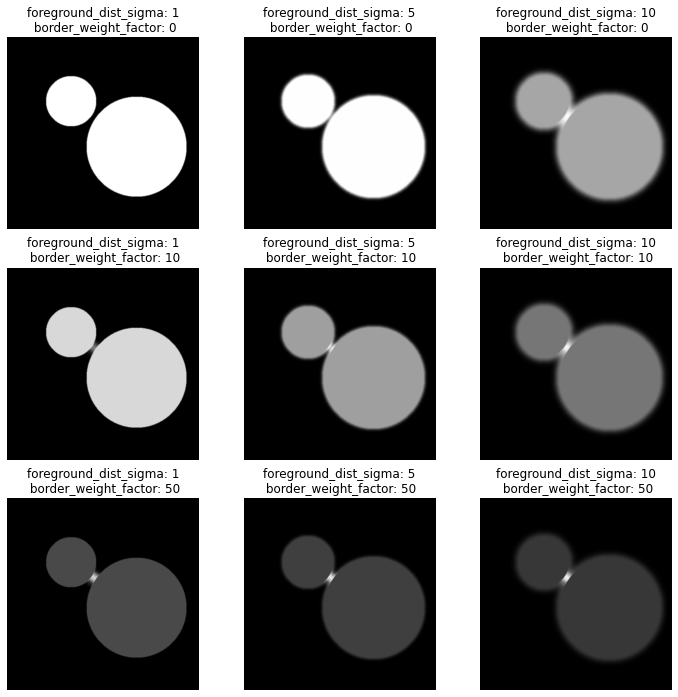

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
i = 0 
for fds in [1,5,10]:
    j = 0
    for bwf in [0, 10, 50]:        
        _, w, _ = calculate_weights(clabels=mask, fds=fds, bwf=bwf)
        axes[j,i].imshow(w,cmap='binary_r')
        axes[j,i].set_axis_off()
        axes[j,i].set_title('foreground_dist_sigma: {}\n border_weight_factor: {}'.format(fds, bwf))
        j+=1
    i += 1
plt.show()

## Data augmentation

Deformation field class to ensure that all augmentations are performed equally on images, masks, and weights. Implemented augmentations are
- rotation
- mirroring
- random deformation

In [ ]:
%nbdev_export
class DeformationField:
    "Creates a deformation field for data augmentation"
    def __init__(self, shape=(540, 540)):
        self.shape = shape
        self.deformationField = np.meshgrid(*[np.arange(d) - d / 2 for d in shape])[::-1]

    def rotate(self, theta=0, phi=0, psi=0):
        "Rotate deformation field"
        if len(self.shape) == 2:
            self.deformationField = [
                self.deformationField[0] * np.cos(theta)
                + self.deformationField[1] * np.sin(theta),
                -self.deformationField[0] * np.sin(theta)
                + self.deformationField[1] * np.cos(theta),
            ]
        else:
            self.deformationField = [
                self.deformationField[0],
                self.deformationField[1] * np.cos(theta)
                + self.deformationField[2] * np.sin(theta),
                -self.deformationField[1] * np.sin(theta)
                + self.deformationField[2] * np.cos(theta),
            ]
            self.deformationField = [
                self.deformationField[0] * np.cos(phi)
                + self.deformationField[2] * np.sin(phi),
                self.deformationField[1]
                - self.deformationField[0] * np.sin(phi)
                + self.deformationField[2] * np.cos(phi),
            ]
            self.deformationField = [
                self.deformationField[0],
                self.deformationField[1] * np.cos(psi)
                + self.deformationField[2] * np.sin(psi),
                -self.deformationField[1] * np.sin(psi)
                + self.deformationField[2] * np.cos(psi),
            ]

    def mirror(self, dims):
        "Mirror deformation fild at dims"
        for d in range(len(self.shape)):
            if dims[d]:
                self.deformationField[d] = -self.deformationField[d]

    def addRandomDeformation(self, grid=(150, 150), sigma=(10, 10)):
        "Add random deformation to the deformation field"
        seedGrid = np.meshgrid(
            *[np.arange(-g / 2, s + g / 2, g) for (g, s) in zip(grid, self.shape)]
        )
        seed = [np.random.normal(0, s, g.shape) for (g, s) in zip(seedGrid, sigma)]
        defFcn = [Rbf(*seedGrid, s, function="cubic") for s in seed]
        targetGrid = np.meshgrid(*map(np.arange, self.shape))
        deformation = [f(*targetGrid) for f in defFcn]
        self.deformationField = [
            f + df for (f, df) in zip(self.deformationField, deformation)
        ]

    def get(self, offset=(0, 0), pad=(0, 0)):
        "Get relevant slice from deformation field"
        sliceDef = tuple(slice(int(p / 2), int(-p / 2)) if p > 0 else None for p in pad)
        deform = [d[sliceDef] for d in self.deformationField]
        return [d + offs for (d, offs) in zip(deform, offset)]

    def apply(self, data, offset=(0, 0), pad=(0, 0), order=1):
        "Apply deformation field to image using interpolation"
        coords = [d.flatten() for d in self.get(offset, pad)]
        outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
        if len(data.shape) == len(self.shape) + 1:
            tile = np.empty((*outshape, data.shape[-1]))
            for c in range(data.shape[-1]):
                tile[..., c] = ndimage.interpolation.map_coordinates(
                    data[..., c], coords, order=order, mode="reflect"
                ).reshape(outshape)
            return tile.astype(data.dtype)
        else:
            return (
                ndimage.interpolation.map_coordinates(
                    data, coords, order=order, mode="reflect")
                .reshape(outshape)
                .astype(data.dtype))

Original Image

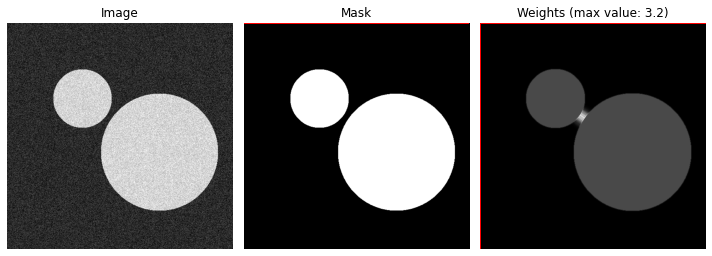

In [ ]:
show(image, labels, weights)

Add mirroring

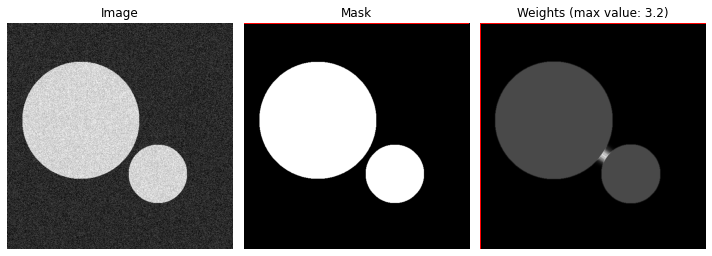

In [ ]:
tst = DeformationField()
tst.mirror((1,1))
show(tst.apply(image, offset=(270,270)), 
     tst.apply(mask, offset=(270,270)), 
     tst.apply(weights, offset=(270,270)))

Add random deformation

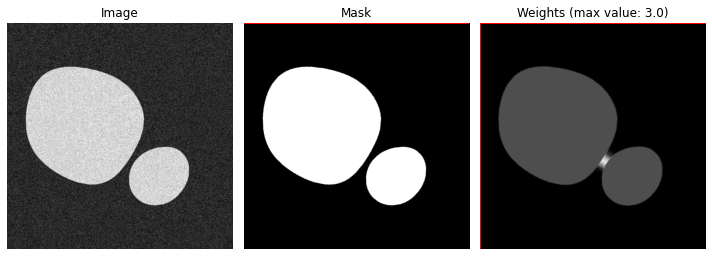

In [ ]:
tst.addRandomDeformation()
show(tst.apply(image, offset=(270,270)), 
     tst.apply(mask, offset=(270,270)), 
     tst.apply(weights, offset=(270,270)))

Add rotation

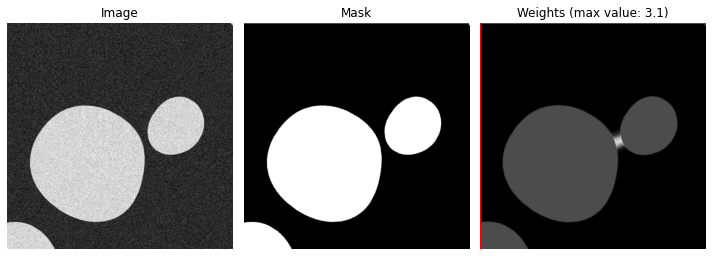

In [ ]:
tst.rotate(1,1,1)
show(tst.apply(image, offset=(270,270)), 
     tst.apply(mask, offset=(270,270)), 
     tst.apply(weights, offset=(270,270)))

## Datasets

Pytorch map-style [datasets](https://pytorch.org/docs/stable/data.html) for training and validation.

### Helper functions

In [ ]:
%nbdev_export
def _read_img(path, divide=None, **kwargs):
    "Read image and normalize to 0-1 range"
    img = imageio.imread(path, **kwargs)
    if divide is None and img.max()>0:
        img = img/np.iinfo(img.dtype).max
    if divide is not None:
        img = img/divide
    assert img.max()<=1. and img.max()>.04, f'Check image loading, dividing by {divide}, max value is {img.max()}'
    if img.ndim == 2:
        img = np.expand_dims(img, axis=2)
    return img

In [ ]:
%nbdev_export
def _read_msk(path, n_classes=2, instance_labels=False, **kwargs):
    "Read image and check classes"
    msk = imageio.imread(path, **kwargs)
    if not instance_labels:
        if np.max(msk)>n_classes:
            msk = msk//np.iinfo(msk.dtype).max
        # Mask check
        assert len(np.unique(msk))==n_classes, 'Check n_classes and provided mask'
    return msk

In [ ]:
%nbdev_export
def _get_cached_data(path):
    "Loads preprocessed and compressed label (mask), weight, and pdf data."
    with open(path, 'rb') as f: 
        tmp = np.load(f)
        return tmp['lbl'], tmp['wgt'], tmp['pdf']

In [ ]:
%nbdev_export
def _cache_fn(ds, o):
    "Creates path to preprocessed and compressed data."
    return Path(ds.preproc_dir)/f'{o}_{ds.bws}_{ds.fds}_{ds.bwf}_{ds.fbr}.npz'

### RandomTileDataset

For training

In [ ]:
%nbdev_export
class RandomTileDataset(Dataset):
    """
    Pytorch Dataset that creates random tiles with augmentations from the input images.
    """
    n_inp = 1
    def __init__(self, 
                 files,
                 label_fn,
                 instance_labels = False,
                 divide=None,
                 n_classes=2,
                 ignore={},
                 tile_shape=(540,540),
                 padding=(184,184),
                 sample_mult=None,
                 rotation_range_deg=(0, 360),
                 flip=True,
                 deformation_grid=(150, 150),
                 deformation_magnitude=(10, 10),
                 value_minimum_range=(0, 0),
                 value_maximum_range=(1, 1),
                 value_slope_range=(1, 1),
                 bws=6, fds=1, bwf=50, fbr=.1,
                 preproc_dir='.preproc_data'): 
        
        store_attr()
        self.c = n_classes
        Path(preproc_dir).mkdir(exist_ok=True)

        for file in progress_bar(files, leave=False):
            try:
                lbl, wgt, pdf = _get_cached_data(_cache_fn(self, file.name))
            except:
                print('Creating weights for', file.name)
                label_path = label_fn(file)
                if instance_labels:
                    clabels = None
                    instlabels = _read_msk(label_path, instance_labels=True)
                else:
                    clabels = _read_msk(label_path, self.c)
                    instlabels = None
                ign = ignore[file.name] if file.name in ignore else None
                lbl, wgt, pdf = calculate_weights(clabels, instlabels, ignore=ign, n_dims=self.c, 
                                                  bws=bws, fds=fds, bwf=bwf, fbr=fbr)
                np.savez_compressed(_cache_fn(self, file.name), lbl=lbl, wgt=wgt, pdf=pdf)

        # Sample mulutiplier: Number of random samplings from augmented image
        self.sample_mult = sample_mult
        if self.sample_mult is None:
            tile_shape = np.array(self.tile_shape)-np.array(self.padding)
            msk_shape = np.array(lbl.shape[-2:])
            self.sample_mult = int(np.product(np.floor(msk_shape/tile_shape)))

        self.on_epoch_end()

    def __len__(self):
        return len(self.files)*self.sample_mult

    def __getitem__(self, idx):
        idx = idx % len(self.files)
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.files[idx]
        img = _read_img(img_path, divide=self.divide)
        n_channels = img.shape[-1]

        labels, weights, pdf = _get_cached_data(_cache_fn(self, img_path.name))
        
        cumulatedPdf = np.cumsum(pdf/np.sum(pdf))
        # Random center
        center = np.unravel_index(np.argmax(cumulatedPdf > np.random.random()), pdf.shape)
        X = self.gammaFcn(self.deformationField.apply(img, center).flatten()).reshape((*self.tile_shape, n_channels))
        X = np.moveaxis(X, -1, 0)
        Y = self.deformationField.apply(labels, center, self.padding, 0)
        # To categorical
        W = self.deformationField.apply(weights, center, self.padding, 1)

        X = X.astype('float32')
        Y = Y.astype('int64')
        W = W.astype('float32')

        return  TensorImage(X), TensorMask(Y), W

    def get_data(self, files=None, max_n=None, mask=False):
        if files is not None:
            files = L(files)
        elif max_n is not None:
            max_n = np.min((max_n, len(self.files)))
            files = self.files[:max_n]
        else: 
            files = self.files
        data_list = L()
        for f in files:
            if mask: d, _, _ = _get_cached_data(_cache_fn(self, f.name))
            else: d = _read_img(f, divide=self.divide)
            data_list.append(d)
        return data_list

    def show_data(self, max_n=6, ncols=1, figsize=None, **kwargs):
        max_n = np.min((max_n, len(self.files)))
        if figsize is None: figsize = (ncols*12, max_n//ncols * 5)
        for i in range(max_n):
            path = self.files[i]
            img = _read_img(path, divide=self.divide)
            lbl, wgt, _ = _get_cached_data(_cache_fn(self, path.name))
            show(img, lbl, wgt, file_name=path.name, figsize=figsize, show_bbox=False, **kwargs)

    def on_epoch_end(self, verbose=False):

        if verbose: print("Generating deformation field")
        self.deformationField = DeformationField(self.tile_shape)

        if self.rotation_range_deg[1] > self.rotation_range_deg[0]:
            self.deformationField.rotate(
                theta=np.pi * (np.random.random()
                            * (self.rotation_range_deg[1] - self.rotation_range_deg[0])
                            + self.rotation_range_deg[0])
                            / 180.0)

        if self.flip:
            self.deformationField.mirror(np.random.choice((True,False),2))

        if self.deformation_grid is not None:
            self.deformationField.addRandomDeformation(
                self.deformation_grid, self.deformation_magnitude)

        if verbose: print("Generating value augmentation function")
        minValue = (self.value_minimum_range[0]
            + (self.value_minimum_range[1] - self.value_minimum_range[0])
            * np.random.random())

        maxValue = (self.value_maximum_range[0]
            + (self.value_maximum_range[1] - self.value_maximum_range[0])
            * np.random.random())

        intermediateValue = 0.5 * (
            self.value_slope_range[0]
            + (self.value_slope_range[1] - self.value_slope_range[0])
            * np.random.random())

        self.gammaFcn = interp1d([0, 0.5, 1.0], [minValue, intermediateValue, maxValue], kind="quadratic")

    #https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch/60803379#60803379
    def compute_stats(self, max_samples=50):
        "Computes mean and std from files"
        mean_sum, var_sum = 0., 0.
        for i, f in enumerate(self.files, 1):
            img = _read_img(f, divide=self.divide)
            mean_sum += img.mean((0,1))
            var_sum += img.var((0,1))
            if i==max_samples:
                print(f'Calculated stats from {i} files')
                continue

        self.mean = mean_sum/i
        self.std = np.sqrt(var_sum/i)
        return ([self.mean], [self.std])

    
Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            tile_shape - The tile shape the network expects as input
            padding - The padding (input shape - output shape)
            classlabels - A list containing the corresponding class labels.
                          0 = ignore, 1 = background, 2-n foreground classes
                          If None, the problem will be treated as binary segmentation
            n_classes - The number of classes including background
            ignore - A list containing the corresponding ignore regions.
            weights - A list containing the corresponding weights.
            element_size_um - The target pixel size in micrometers
            batch_size - The number of tiles to generate per batch
            rotation_range_deg - (alpha_min, alpha_max): The range of rotation angles.
                                 A random rotation is drawn from a uniform distribution
                                 in the given range
            flip - If true, a coin flip decides whether a mirrored tile will be
                   generated
            deformation_grid - (dx, dy): The distance of neighboring grid points in
                               pixels for which random deformation vectors are drawn
            deformation_magnitude - (sx, sy): The standard deviations of the
                                    Gaussians, the components of the deformation
                                    vector are drawn from
            value_minimum_range - (v_min, v_max): Input intensity zero will be mapped
                                  to a random value in the given range
            value_maximum_range - (v_min, v_max): Input intensity one will be mapped
                                  to a random value within the given range
            value_slope_range - (s_min, s_max): The slope at control points is drawn
                                from a uniform distribution in the given range

Show data

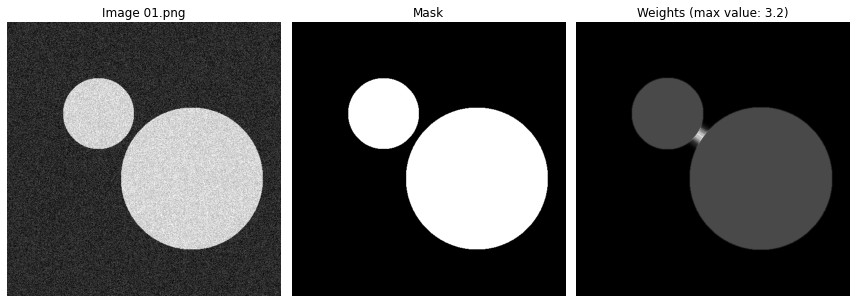

In [ ]:
path = Path('sample_data')
files = get_image_files(path/'images')
label_fn = lambda o: path/'labels'/f'{o.stem}_mask{o.suffix}'
tst = RandomTileDataset(files, label_fn)
tst.show_data()

Show random tile (default padding = (184,184))

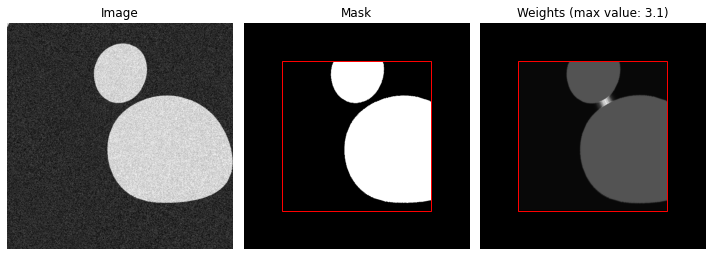

In [ ]:
tile = tst[0]
show(tile[0], tile[1], tile[2])

Compute stats

In [ ]:
tst.compute_stats()

([array([0.3425792])], [array([0.30917143])])

### TileDataset

In [ ]:
%nbdev_export
class TileDataset(Dataset):
    "Pytorch Dataset that creates random tiles for validation and prediction on new data."
    n_inp = 1
    def __init__(self,
                 files,
                 label_fn=None,
                 instance_labels = False,
                 n_classes=2,
                 divide=None,
                 ignore={},
                 tile_shape=(540,540),
                 padding=(184,184),
                 bws=6, fds=1, bwf=50, fbr=.1,
                 preproc_dir='.preproc_data'):

        store_attr()
        self.c = n_classes
        Path(preproc_dir).mkdir(exist_ok=True)
        self.output_shape = tuple(int(t - p) for (t, p) in zip(tile_shape, padding))

        tiler = DeformationField(tile_shape)
        self.tile_data = []
        self.tile_labels = [] if self.label_fn is not None else None
        self.tile_weights = [] if self.label_fn is not None else None
        self.image_indices = []
        self.image_shapes = []
        self.in_slices = []
        self.out_slices = []

        
        for i, file in enumerate(progress_bar(files, leave=False)):
            if self.label_fn is not None:
                try:
                    lbl, wgt, pdf = _get_cached_data(_cache_fn(self, file.name))
                except:
                    print('Creating weights for', file.name)
                    label_path = label_fn(file)
                    if instance_labels:
                        clabels = None
                        instlabels = _read_msk(label_path, instance_labels=True)
                    else:
                        clabels = _read_msk(label_path, self.c)
                        instlabels = None
                    ign = ignore[path.name] if file.name in ignore else None
                    lbl, wgt, pdf = calculate_weights(clabels, instlabels, ignore=ign, n_dims=self.c, 
                                                      bws=bws, fds=fds, bwf=bwf, fbr=fbr)
                    np.savez_compressed(_cache_fn(self, file.name), lbl=lbl, wgt=wgt, pdf=pdf)

            img = _read_img(file, divide=self.divide)

            # Tiling
            data_shape = img.shape[:-1]
            for ty in range(int(np.ceil(data_shape[0] / self.output_shape[0]))):
                for tx in range(int(np.ceil(data_shape[1] / self.output_shape[1]))):
                    centerPos = (
                        int((ty + 0.5) * self.output_shape[0]),
                        int((tx + 0.5) * self.output_shape[1]),
                    )
                    self.tile_data.append(tiler.apply(img, centerPos))
                    if self.label_fn is not None:
                        self.tile_labels.append(
                            tiler.apply(lbl, centerPos, padding, order=0)
                        )
                        self.tile_weights.append(
                            tiler.apply(wgt, centerPos, padding, order=1)
                        )
                    self.image_indices.append(i)
                    self.image_shapes.append(data_shape)
                    sliceDef = tuple(
                        slice(tIdx * o, min((tIdx + 1) * o, s))
                        for (tIdx, o, s) in zip((ty, tx), self.output_shape, data_shape)
                    )
                    self.out_slices.append(sliceDef)
                    sliceDef = tuple(
                        slice(0, min((tIdx + 1) * o, s) - tIdx * o)
                        for (tIdx, o, s) in zip((ty, tx), self.output_shape, data_shape)
                    )
                    self.in_slices.append(sliceDef)
                        
    def __len__(self):
        return len(self.tile_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = np.moveaxis(self.tile_data[idx] , -1, 0).astype('float32')

        if self.label_fn is not None:
            Y = self.tile_labels[idx].astype('int64')
            W = self.tile_weights[idx].astype('float32')
            return TensorImage(X), TensorMask(Y), W
        else:
            return TensorImage(X)

    def get_images(self, max_n=None):
        if max_n is not None:
            max_n = np.min((max_n, len(self.files)))
        else:
            max_n = len(self.files)
        img_list = []
        for i in range(max_n):
            path = self.files[i]
            img_list.append(_read_img(path, divide=self.divide))
        return img_list

    def show_data(self, max_n=6, ncols=1, figsize=None, **kwargs):
        max_n = np.min((max_n, len(self.files)))
        if figsize is None: figsize = (ncols*12, max_n//ncols * 5)
        for i in range(max_n):
            path = self.files[i]
            img = _read_img(path, divide=self.divide)
            if self.label_fn is not None:
                lbl, wgt, _ = _get_cached_data(_cache_fn(self, path.name))
                show(img, lbl, wgt, file_name=path.name, figsize=figsize, show_bbox=False, **kwargs)
            else:
                lbl= np.zeros_like(img)
                show(img, lbl, file_name=path.name, figsize=figsize, show_bbox=False, **kwargs)



    def reconstruct_from_tiles(self, tiles):
        "Reconstruct masks or predictions from list of tiles"

        assert isinstance(tiles, list), "You need to pass a list"
        assert len(tiles) == len(self), f"Tile list must have length{len(self)}"

        out_ll = []
        for idx in range(len(self)):
            outIdx = self.image_indices[idx]
            outShape = self.image_shapes[idx]
            outSlice = self.out_slices[idx]
            inSlice = self.in_slices[idx]
            if len(out_ll) < outIdx + 1:
                if len(tiles[0].shape)>2:
                    out_ll.append(np.empty((*outShape, self.c)))
                else:
                    out_ll.append(np.empty(outShape))
            out_ll[outIdx][outSlice] = tiles[idx][inSlice]

        return out_ll

Show data

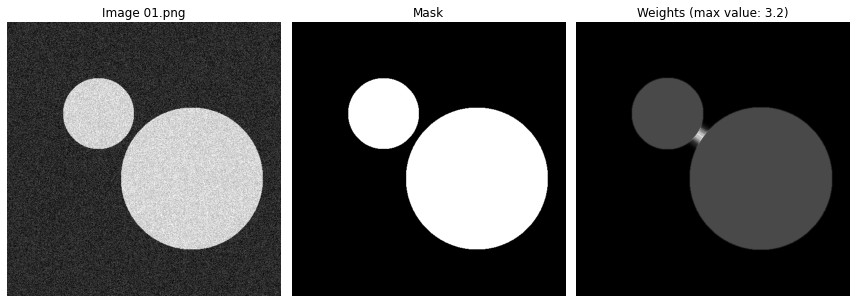

In [ ]:
path = Path('sample_data')
files = get_image_files(path/'images')
label_fn = lambda o: path/'labels'/f'{o.stem}_mask{o.suffix}'
tst = TileDataset(files, label_fn, tile_shape=(450,450), padding=(10,10))
tst.show_data()

Show tiles

Tile 0


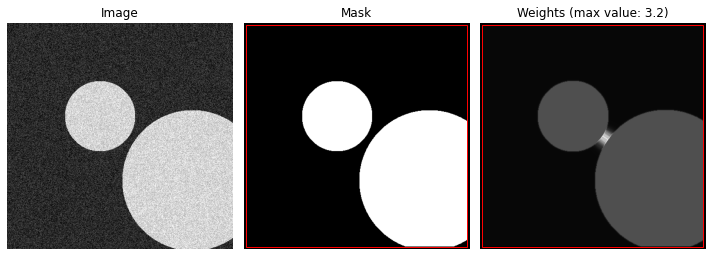

Tile 1


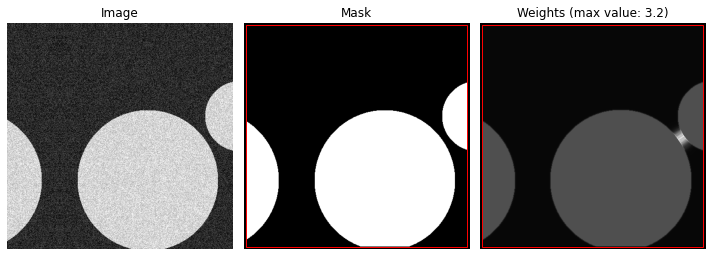

Tile 2


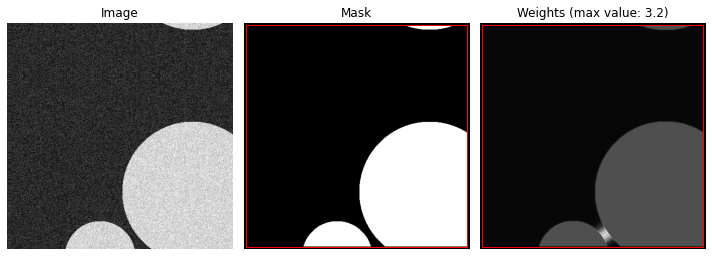

Tile 3


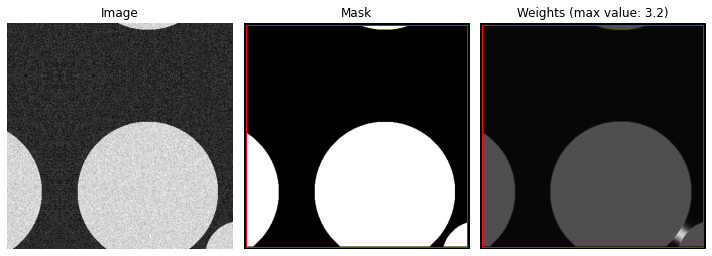

In [ ]:
for i in range(len(tst)): 
    print(f'Tile {i}')
    tile = tst[i]
    show(tile[0], tile[1], tile[2])

Reconstruct masks

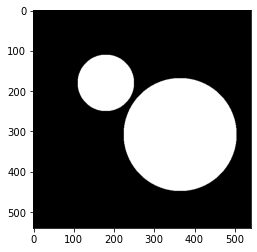

In [ ]:
msk_tiles = [x[1] for x in tst]
msk = tst.reconstruct_from_tiles(msk_tiles)
plt.imshow(msk[0], cmap='binary_r');

## Export -

In [ ]:
%nbdev_hide
from nbdev.export import *
notebook2script()

Converted 00_learner.ipynb.
Converted 01_models.ipynb.
Converted 02_data.ipynb.
Converted 03_metrics.ipynb.
Converted 04_callbacks.ipynb.
Converted 05_losses.ipynb.
Converted 06_utils.ipynb.
Converted gt_estimation.ipynb.
Converted index.ipynb.
Converted train.ipynb.
